In [23]:
# [기본 세팅] ------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import seaborn as sns 
from IPython.display import display

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 윈도우 한글 폰트 + 마이너스 표시 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 표시에 도움되는 옵션 (너무 길게 줄바꿈되는 것 방지)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

print("✅ 기본 세팅 완료")

✅ 기본 세팅 완료


In [2]:
# === [번들에서 복원] ===
import pickle

BUNDLE_PATH = "_snapshots/olist_clean_bundle.pkl"

with open(BUNDLE_PATH, "rb") as f:
    bundle = pickle.load(f)

# 변수로 바로 풀어서 사용
orders_clean       = bundle["orders_clean"]
order_items_clean  = bundle["order_items_clean"]
payments_clean     = bundle["payments_clean"]
reviews_clean      = bundle["reviews_clean"]
customers_clean    = bundle["customers_clean"]
geolocation_clean  = bundle["geolocation_clean"]
products_clean     = bundle["products_clean"]
sellers_clean      = bundle["sellers_clean"]
category_tr_clean  = bundle["category_tr_clean"]
rfm =   bundle["rfm"]

print("✅ Restored all *_clean DataFrames")

✅ Restored all *_clean DataFrames


In [16]:
# category_en 보장
def ensure_category_en(products_clean, category_tr_clean=None):
    if "category_en" in products_clean.columns:
        return products_clean
    prod = products_clean.copy()
    if (category_tr_clean is not None) and ("product_category_name" in prod.columns):
        m = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
        prod["category_en"] = prod["product_category_name"].map(m).fillna("unknown")
    else:
        prod["category_en"] = prod.get("product_category_name", "unknown")
    return prod

# 개월차 안전 계산
def month_diff(end, start):
    m = (end.dt.year - start.dt.year) * 12 + (end.dt.month - start.dt.month)
    m = m.astype("float")
    m[(end.isna()) | (start.isna())] = np.nan
    return m

In [17]:
# B) 파라미터
MIN_MONTHS = 6     # SKU 활동 개월(품질필터)
MIN_ORDERS = 12    # SKU 누적 주문수(품질필터)
TOP_CAT_N  = 6     # 상위 카테고리 개수(시각화 대상)

# 1) 카테고리명 보장
products_clean = ensure_category_en(products_clean, category_tr_clean if "category_tr_clean" in globals() else None)

# 2) 분석 베이스 (주문 × 품목 × 상품)
valid_status = ["delivered","invoiced","shipped","processing","created"]
base = (orders_clean[["order_id","customer_id","order_purchase_timestamp","order_status"]]
        .merge(order_items_clean[["order_id","product_id","price"]], on="order_id", how="inner")
        .merge(products_clean[["product_id","category_en"]], on="product_id", how="left"))
base = base[base["order_status"].isin(valid_status)].copy()
base["order_date"]  = pd.to_datetime(base["order_purchase_timestamp"], errors="coerce").dt.normalize()
base["order_month"] = base["order_date"].dt.to_period("M").dt.to_timestamp()
base["category_en"] = base["category_en"].fillna("unknown")

# 3) 제품×월 매출
prod_m = (base.groupby(["product_id","category_en","order_month"])["price"]
            .sum().reset_index().rename(columns={"price":"sales"})).sort_values(["product_id","order_month"])

# 4) 제품 메타 (출시/종료/피크/나이/피크까지 시간)
first_last = prod_m.groupby("product_id")["order_month"].agg(first_month="min", last_month="max").reset_index()
peak_idx   = prod_m.groupby("product_id")["sales"].idxmax()
peak_map   = prod_m.loc[peak_idx, ["product_id","order_month"]].rename(columns={"order_month":"peak_month"})

sku_orders = base.groupby("product_id")["order_id"].nunique().rename("orders_total").reset_index()
sku_sales  = base.groupby("product_id")["price"].sum().rename("sales_total").reset_index()

meta = (first_last
        .merge(peak_map, on="product_id", how="left")
        .merge(products_clean[["product_id","category_en"]], on="product_id", how="left")
        .merge(sku_orders, on="product_id", how="left")
        .merge(sku_sales,  on="product_id", how="left"))
meta["age_months"]   = month_diff(meta["last_month"], meta["first_month"]) + 1.0
meta["time_to_peak"] = month_diff(meta["peak_month"], meta["first_month"])

# 5) 단계(stage) 판정: 최근3개월 MA vs 직전3개월 MA
prod_m["ma3"] = prod_m.groupby("product_id")["sales"].transform(lambda s: s.rolling(3, min_periods=1).mean())
def _stage_of_product(g, recent=3, prev=3):
    g = g.sort_values("order_month")
    if len(g) < (recent+prev): return "introduction"
    last = g["ma3"].tail(recent).mean()
    prv  = g["ma3"].tail(recent+prev).head(prev).mean()
    if prv <= 0: return "introduction"
    delta = (last - prv) / prv
    if len(g) <= 3: return "introduction"
    if delta >= 0.15: return "growth"
    if delta <= -0.15 and len(g) >= 6: return "decline"
    if abs(delta) < 0.10: return "mature"
    return "mature"

stage_map = {pid: _stage_of_product(g) for pid, g in prod_m.groupby("product_id", sort=False)}
meta["stage"] = meta["product_id"].map(stage_map)

# 6) 품질필터 & 시각화 대상 카테고리(최근 12개월 매출 Top N)
mask_stable = (meta["age_months"] >= MIN_MONTHS) & (meta["orders_total"] >= MIN_ORDERS)
meta_stable = meta.loc[mask_stable].copy()

last_month = base["order_month"].max()
cut_12     = last_month - pd.DateOffset(months=11)
top_cats   = (base[base["order_month"]>=cut_12]
              .groupby("category_en")["price"].sum()
              .sort_values(ascending=False).head(TOP_CAT_N).index.tolist())

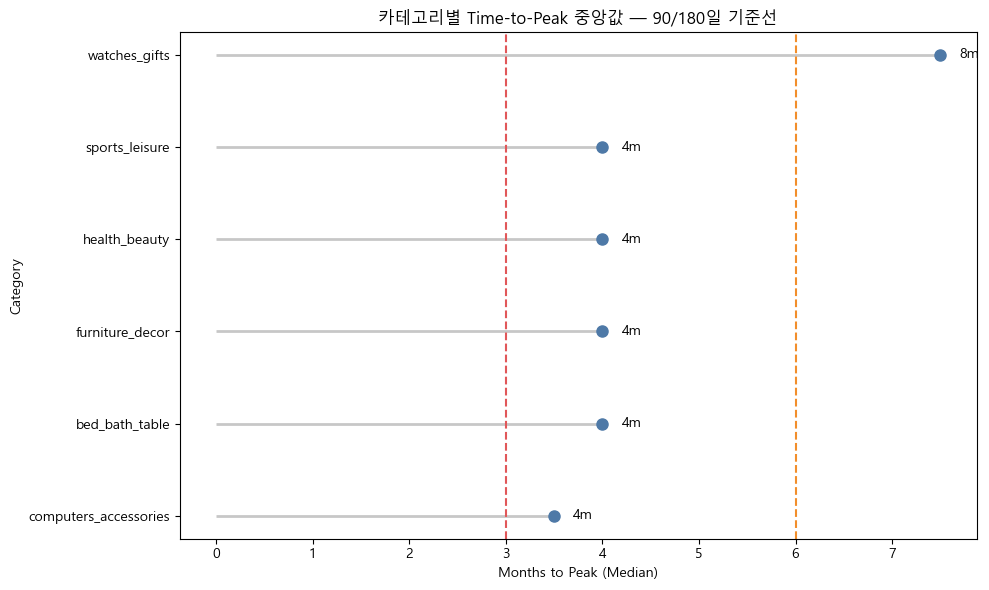

In [18]:
# C) TTP 로리팝
ttp_by_cat = (meta_stable.groupby("category_en")["time_to_peak"]
              .median().dropna())
sel = ttp_by_cat.loc[ttp_by_cat.index.isin(top_cats)].sort_values()

if len(sel) > 0:
    plt.figure(figsize=(10, 6))
    y = np.arange(len(sel))
    # 가이드 라인 + 포인트
    plt.hlines(y, xmin=0, xmax=sel.values, color="#C7C7C7", linewidth=2)
    plt.plot(sel.values, y, "o", color="#4E79A7", markersize=8)
    # 라벨(개월)
    for i, (cat, v) in enumerate(sel.items()):
        plt.text(float(v)+0.2, i, f"{v:.0f}m", va="center", fontsize=10)
    # 기준선(90/180일)
    plt.axvline(3, color="#E15759", linestyle="--", linewidth=1.5)
    plt.axvline(6, color="#F28E2B", linestyle="--", linewidth=1.5)

    plt.yticks(y, sel.index)
    plt.xlabel("Months to Peak (Median)")
    plt.ylabel("Category")
    plt.title("카테고리별 Time-to-Peak 중앙값 — 90/180일 기준선")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ time_to_peak 중앙값이 있는 카테고리가 없습니다.")

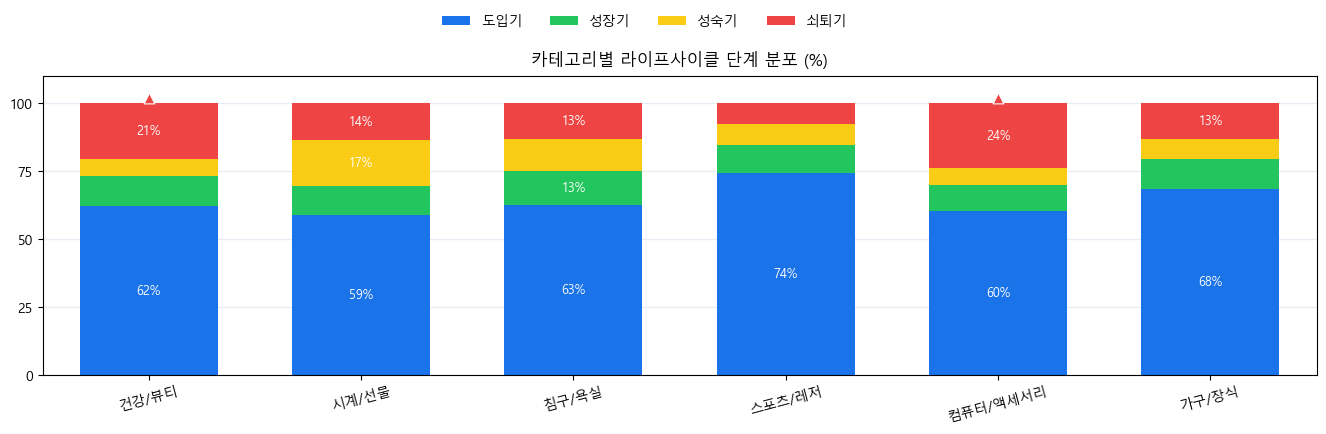

In [24]:
# D) 매출가중 라이프사이클 스택바

# 1) 단계별 매출 비중 피벗 (index=카테고리, columns=stage, values=share)
stage_rev = (base[["product_id","price"]]
                .merge(meta[["product_id","category_en","stage"]], on="product_id", how="left")
                .groupby(["category_en","stage"])["price"].sum()
                .reset_index().rename(columns={"price":"sales"}))

cat_total = stage_rev.groupby("category_en")["sales"].sum().rename("cat_sales")
stage_rev = stage_rev.merge(cat_total, on="category_en", how="left")
stage_rev["share"] = stage_rev["sales"] / stage_rev["cat_sales"]

stages_order = ["introduction","growth","mature","decline"]
pivot = (stage_rev.pivot(index="category_en", columns="stage", values="share")
                  .reindex(index=top_cats, columns=[s for s in stages_order if s in stage_rev["stage"].unique()])
                  .fillna(0.0))

# 2) 시각화(라벨, 경고마커 포함)
LABEL_MIN     = 0.12     # 이 비율 이상만 퍼센트 라벨 표기
DECLINE_ALERT = 0.20     # 쇠퇴기 비중 경고 임계값 (삼각형)
WARN_Y        = 1.02
BAR_W         = 0.65

cols   = list(pivot.columns)                  # 실제 존재하는 단계만
vals   = pivot.to_numpy(dtype=np.float32)
x      = np.arange(vals.shape[0], dtype=np.float32)
bottom = np.zeros_like(x, dtype=np.float32)

colors = {"introduction":"#1a73e8","growth":"#22c55e","mature":"#facc15","decline":"#ef4444"}
labels_kr = {"introduction":"도입기","growth":"성장기","mature":"성숙기","decline":"쇠퇴기"}

# (선택) 카테고리 한글 매핑
cat_kr_map = {
    "health_beauty": "건강/뷰티",
    "watches_gifts": "시계/선물",
    "bed_bath_table": "침구/욕실",
    "sports_leisure": "스포츠/레저",
    "computers_accessories": "컴퓨터/액세서리",
    "furniture_decor": "가구/장식",
}

fig, ax = plt.subplots(figsize=(14, 4.6))
ax.set_axisbelow(True)
ax.grid(axis="y", color="#e9edf3", linewidth=1.0)

for j, s in enumerate(cols):
    v = vals[:, j]
    ax.bar(x, v, width=BAR_W, bottom=bottom, color=colors.get(s, "#999999"),
           label=labels_kr.get(s, s))
    # 퍼센트 라벨(일부만)
    mid = bottom + v/2
    for xi, yi, vi in zip(x, mid, v):
        if vi >= LABEL_MIN:
            ax.text(float(xi), float(yi), f"{vi*100:.0f}%", ha="center", va="center",
                    fontsize=9, color="white")
    bottom += v

# 쇠퇴기 경고 삼각형
if "decline" in pivot.columns:
    d = pivot["decline"].to_numpy(dtype=np.float32)
    mask = d >= DECLINE_ALERT
    ax.scatter(x[mask], np.full(mask.sum(), WARN_Y, dtype=np.float32),
               marker="^", s=60, color=colors["decline"], edgecolors="white", linewidths=0.8, zorder=4)

ax.set_ylim(0.0, 1.10)
ax.set_xlim(-0.5, len(x)-0.5)
ax.set_xticks(x, [cat_kr_map.get(c, c) for c in pivot.index], rotation=15)

ax.yaxis.set_major_locator(mticker.MultipleLocator(0.25))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, p: f"{int(v*100)}"))

ax.set_title("카테고리별 라이프사이클 단계 분포 (%)", pad=8)

# 명시적 범례(색상 고정)
handles = [mpatches.Patch(facecolor=colors[c], label=labels_kr.get(c, c)) for c in cols]
fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.99),
           ncol=len(cols), frameon=False)

plt.subplots_adjust(top=0.83, bottom=0.18, left=0.07, right=0.98)
plt.show()
